In [11]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("telco_cluster").getOrCreate()

df = spark.read.csv("/Churn.csv", header=True, inferSchema=True)
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [12]:
from pyspark.sql.functions import col, when

# Convert Yes/No to 1/0 for features
df = df.withColumn("PhoneService", when(col("PhoneService") == "Yes", 1).otherwise(0)) \
       .withColumn("InternetService", when(col("InternetService") == "No", 0).otherwise(1)) \
       .withColumn("BothServices", (col("PhoneService") + when(col("InternetService") == "No", 0).otherwise(1)))

# Optional: Drop rows with nulls
df = df.select("PhoneService", "InternetService", "BothServices").dropna()
df.show(5)

+------------+---------------+------------+
|PhoneService|InternetService|BothServices|
+------------+---------------+------------+
|           0|              1|           1|
|           1|              1|           2|
|           1|              1|           2|
|           0|              1|           1|
|           1|              1|           2|
+------------+---------------+------------+
only showing top 5 rows



In [13]:
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(
    inputCols=["PhoneService", "InternetService", "BothServices"],
    outputCol="features"
)

final_data = vec_assembler.transform(df)

In [14]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(final_data)
cluster_data = scaler_model.transform(final_data)


In [15]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol='scaledFeatures', k=3)
model = kmeans.fit(cluster_data)

# Add predictions
predictions = model.transform(cluster_data)


In [16]:
predictions.groupBy("prediction").count().show()


+----------+-----+
|prediction|count|
+----------+-----+
|         1|  682|
|         2| 4835|
|         0| 1526|
+----------+-----+



In [17]:
predictions.select("PhoneService", "InternetService", "BothServices", "prediction").show(10)


+------------+---------------+------------+----------+
|PhoneService|InternetService|BothServices|prediction|
+------------+---------------+------------+----------+
|           0|              1|           1|         1|
|           1|              1|           2|         2|
|           1|              1|           2|         2|
|           0|              1|           1|         1|
|           1|              1|           2|         2|
|           1|              1|           2|         2|
|           1|              1|           2|         2|
|           0|              1|           1|         1|
|           1|              1|           2|         2|
|           1|              1|           2|         2|
+------------+---------------+------------+----------+
only showing top 10 rows



In [18]:
predictions.groupBy("prediction").count().show()


+----------+-----+
|prediction|count|
+----------+-----+
|         1|  682|
|         2| 4835|
|         0| 1526|
+----------+-----+



In [19]:
predictions.groupBy("prediction").mean("PhoneService", "InternetService", "BothServices").show()


+----------+-----------------+--------------------+-----------------+
|prediction|avg(PhoneService)|avg(InternetService)|avg(BothServices)|
+----------+-----------------+--------------------+-----------------+
|         1|              0.0|                 1.0|              1.0|
|         2|              1.0|                 1.0|              2.0|
|         0|              1.0|                 0.0|              2.0|
+----------+-----------------+--------------------+-----------------+



In [20]:
for idx, center in enumerate(model.clusterCenters()):
    print(f"Cluster {idx}: {center}")


Cluster 0: [3.38120864 0.         6.76241727]
Cluster 1: [0.         2.42715826 3.38120864]
Cluster 2: [3.38120864 2.42715826 6.76241727]


In [24]:
cluster_map = {
    0: "Phone User",
    1: "Both Services",
    2: "Internet User"
}



In [25]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Create UDF to map cluster number to label
def map_cluster_label(cluster_id):
    return cluster_map.get(cluster_id, "Unknown")

label_udf = udf(map_cluster_label, StringType())

# Add new column with readable labels
predictions_labeled = predictions.withColumn("User_Type", label_udf(predictions["prediction"]))


In [26]:
predictions_labeled.select("PhoneService", "InternetService", "BothServices", "prediction", "User_Type").show(10)


+------------+---------------+------------+----------+-------------+
|PhoneService|InternetService|BothServices|prediction|    User_Type|
+------------+---------------+------------+----------+-------------+
|           0|              1|           1|         1|Both Services|
|           1|              1|           2|         2|Internet User|
|           1|              1|           2|         2|Internet User|
|           0|              1|           1|         1|Both Services|
|           1|              1|           2|         2|Internet User|
|           1|              1|           2|         2|Internet User|
|           1|              1|           2|         2|Internet User|
|           0|              1|           1|         1|Both Services|
|           1|              1|           2|         2|Internet User|
|           1|              1|           2|         2|Internet User|
+------------+---------------+------------+----------+-------------+
only showing top 10 rows



In [44]:
pandas_df = predictions_labeled.select(
    "PhoneService", "InternetService", "BothServices", "User_Type"
).toPandas()


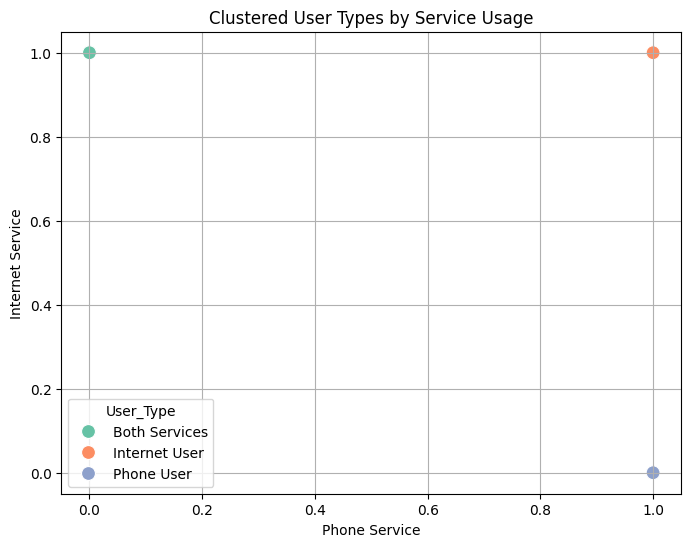

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pandas_df,
    x="PhoneService",
    y="InternetService",
    hue="User_Type",
    palette="Set2",
    s=100
)
plt.title("Clustered User Types by Service Usage")
plt.xlabel("Phone Service")
plt.ylabel("Internet Service")
plt.grid(True)
plt.show()


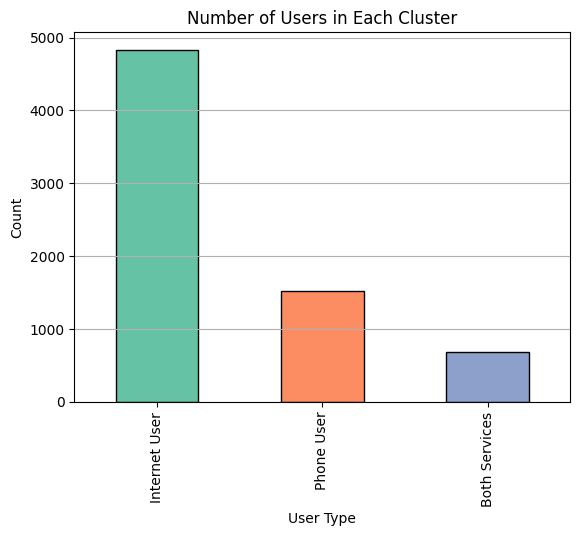

In [46]:
pandas_df["User_Type"].value_counts().plot(
    kind="bar",
    color=["#66c2a5", "#fc8d62", "#8da0cb"],
    edgecolor="black"
)
plt.title("Number of Users in Each Cluster")
plt.xlabel("User Type")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()


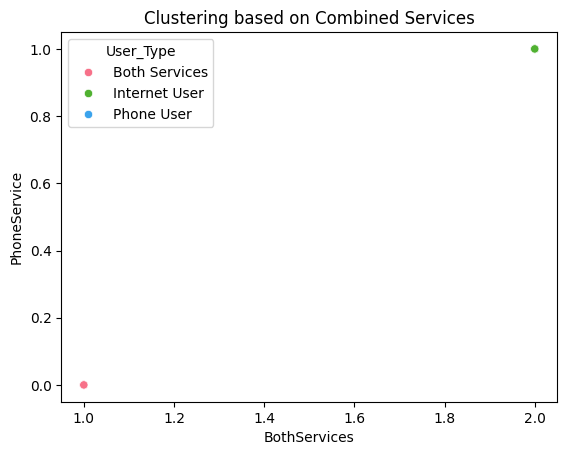